In [134]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import Counter


sys.path.append('../') #change this when package works PR27
from georules.utils import load_list_json


### Load Data

In [126]:
### Transition Matrix plot
transition_matrix = [[0.1,0.13,0.3,0.15,0.22,0.1],
                     [0.3,0.05,0.3,0.15,0.15,0.05],
                     [0.3,0.13,0.1,0.15,0.18,0.14],
                     [0.25,0.1,0.25,0.09,0.22,0.09],
                     [0.05,0.25,0.25,0.25,0.05,0.15],
                     [0.15,0.25,0.25,0.25,0.05,0.05]]
columns = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')
rows = ('Q1', 'Q2', 'Q3', 'Q4', 'NMA','HF')

### Frequency of Markov-States
#input 
n_test = 50

#list that will have quadrants (Markov State) for all realizations
total_quadrants = []

for n in range(1,n_test):
    #combine the lists of quadrants
    total_quadrants = total_quadrants +  load_list_json("quadrants{}".format(n),'/Users/natalychacon/Documents/my_GitHub_repo/georule/georules/georules/3d_grid_inputs/')

# Calculate the frequency of each quadrant
frequency_counter = Counter(total_quadrants)

# Extract the quadrants and their frequencies
quadrants = list(frequency_counter.keys())
frequencies = list(frequency_counter.values())

#Calculate percentages from frequencies
frequencies_percentage = [ i * 100/sum(frequencies) for i in frequencies]

### Markov Equilibrium Distribution





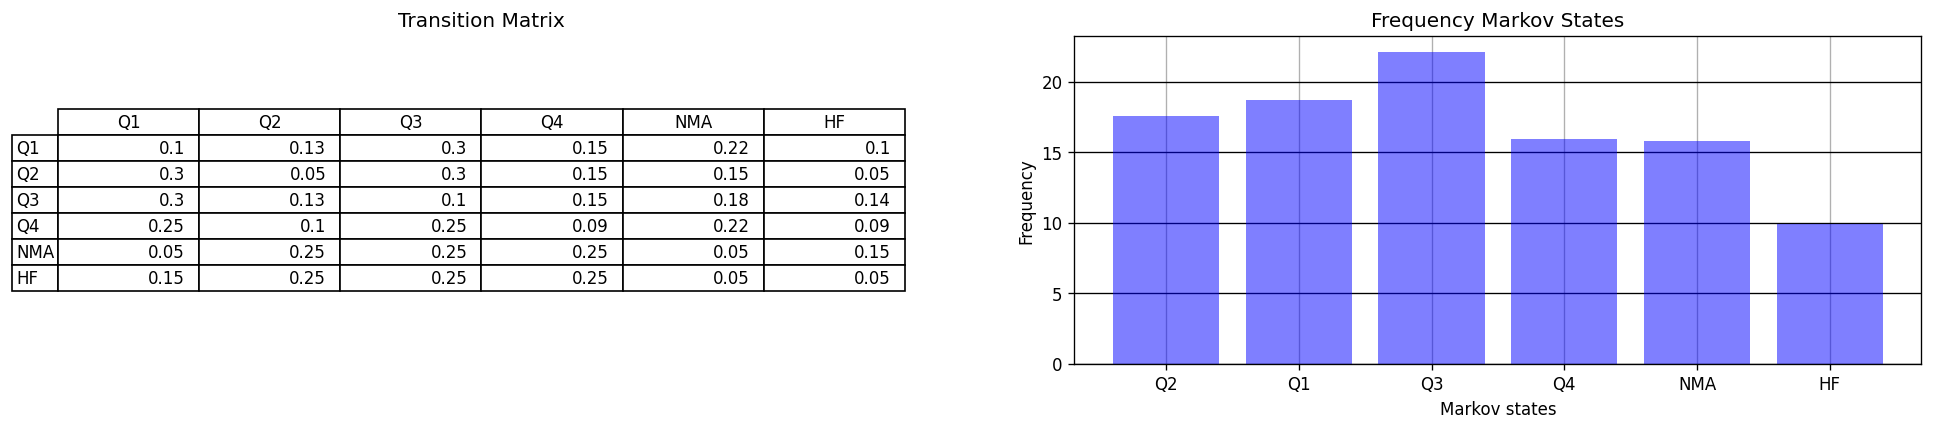

In [133]:
fig = plt.figure(figsize=(12, 6),dpi=120)
grid_spec = gridspec.GridSpec(ncols = 3,nrows=2,width_ratios=[2, 2, 2])

ax0 = fig.add_subplot(grid_spec[0])
ax0.axis('tight')
ax0.axis('off')
the_table = ax0.table(cellText=transition_matrix,rowLabels=rows,colLabels=columns,loc='center')
plt.title('Transition Matrix')

ax1 = fig.add_subplot(grid_spec[1])
# Plot the bar graph
plt.grid()
plt.bar(quadrants, frequencies_percentage, color='blue', zorder=2,alpha =0.5)
# Plot the grid with a lower zorder value
plt.grid(axis='y', zorder=1,color ='black')
plt.xlabel('Markov states')
plt.ylabel('Frequency')
plt.title('Frequency Markov States')


ax1 = fig.add_subplot(grid_spec[2])
# Plot the bar graph
plt.grid()
plt.bar(quadrants, frequencies_percentage, color='blue', zorder=2,alpha =0.5)
# Plot the grid with a lower zorder value
plt.grid(axis='y', zorder=1,color ='black')
plt.xlabel('Markov states')
plt.ylabel('Frequency')
plt.title('Frequency Markov States')



plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 6),dpi=120)
fig, axs = plt.subplots(2, 3)
#grid_spec = gridspec.GridSpec(ncols = 3,nrows=2,width_ratios=[2, 2, 2])

ax0 = fig.add_subplot(grid_spec[0])
ax0.axis('tight')
ax0.axis('off')
the_table = ax0.table(cellText=transition_matrix,rowLabels=rows,colLabels=columns,loc='center')
plt.title('Transition Matrix')

ax1 = fig.add_subplot(grid_spec[1])
# Plot the bar graph
plt.grid()
plt.bar(quadrants, frequencies, color='blue', zorder=2)
# Plot the grid with a lower zorder value
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)
plt.xlabel('Markov states')
plt.ylabel('Frequency')
plt.show()





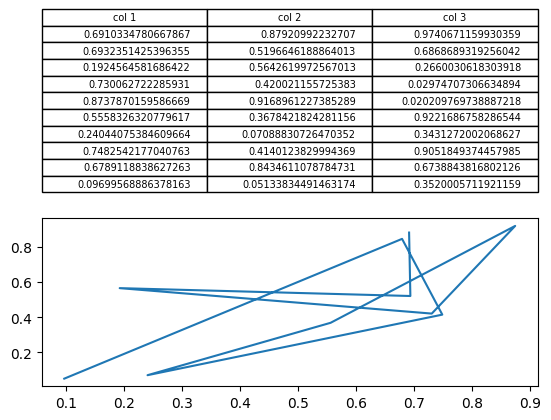

In [33]:
fig, axs =plt.subplots(2,1)
clust_data = np.random.random((10,3))
collabel=("col 1", "col 2", "col 3")
axs[0].axis('tight')
axs[0].axis('off')
the_table = axs[0].table(cellText=clust_data,colLabels=collabel,loc='center')

axs[1].plot(clust_data[:,0],clust_data[:,1])
plt.show()